## Music Style Detector : CNN with Mel Spectogram

This notebook contains experimentation to create a music style detector by building a CNN model with Mel spectogram as input. The model is trained on a custom part of the FMA dataset and evaluated on the GTZAN dataset.

### 1. Imports and setup

In [103]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
from torchmetrics.functional import accuracy, confusion_matrix
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
import wandb
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
import random
import os
import json

# PATHS
MODEL_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..', 'models', 'genre_detector'))
DATA_DIR = os.path.join(MODEL_DIR, 'data')

config =  {
    'audio_duration': 10000, # in ms
    'sample_rate': 44100,
    'n_channels': 2,
    'time_shift': 0.2, # in percentage
    'batch_size': 32,
}

In [104]:
# WandB logger
wandb_logger = WandbLogger(project='genre-detection-tuning', entity='mlodimage', log_model="all")

# CONFIG
wandb_logger.experiment.config.update({
    'audio_duration': 10000, # in ms
    'sample_rate': 44100,
    'n_channels': 2,
    'time_shift': 0.2, # in percentage
    'batch_size': 32,
    'lr': 0.001,
    'max_epochs': 100,
})

config = wandb_logger.experiment.config

/home/benjy/anaconda3/envs/pi_mlodimage/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


### 2. Data pre-processing

In [105]:
class AudioUtils():
    """
    Utility class for audio processing.
    """
    @staticmethod
    def open(audio_file: str):
        """
        Load an audio file. Return the signal as a tensor and the sample rate.
        :param audio_file : Path to the audio file.
        :type audio_file : str
        :return: signal as a tensor and the sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = torchaudio.load(audio_file)
        return signal, sample_rate
    
    @staticmethod
    def rechannel(audio, new_channel):
        """
        Convert a given audio to the specified number of channels.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_channel: the target number of channels
        :type new_channel: int
        :return: the audio with the target number of channels
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio

        if signal.shape[0] == new_channel:
            # nothing to do as the signal already has the target number of channels
            return audio
        if new_channel == 1:
            # convert to mono by selecting only the first channel
            signal = signal[:1, :]
        else:
            # convert to stereo by duplicating the first channel
            signal = torch.cat([signal, signal])
        return signal, sample_rate
    
    @staticmethod
    def resample(audio, new_sample_rate):
        """
        Change the sample rate of the audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_sample_rate: the target sample rate
        :type new_sample_rate: int
        :return: the audio with the target sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        if sample_rate == new_sample_rate:
            # nothing to do
            return audio
        resample = torchaudio.transforms.Resample(sample_rate, new_sample_rate)
        signal = resample(signal)
        return signal, new_sample_rate
    
    @staticmethod
    def pad_truncate(audio, length):
        """
        Pad or truncate an audio signal to a fixed length (in ms).
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param length: the target length in ms
        :type length: int
        :return: the audio with the target length
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        max_length = sample_rate//1000 * length

        if signal.shape[1] > max_length:
            signal = signal[:, :max_length]
        elif signal.shape[1] < max_length:
            padding = max_length - signal.shape[1]
            signal = F.pad(signal, (0, padding))
        return signal, sample_rate

    @staticmethod
    def time_shift(audio, shift_limit):
        """
        Shift the signal to the left or right by some percent. Values at the end
        are 'wrapped around' to the start of the transformed signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param shift_limit: the maximum shift to apply (in percent)
        :type shift_limit: int
        :return: the shifted audio
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        _, signal_length = signal.shape
        shift_amount = int(random.random() * shift_limit * signal_length)
        return (signal.roll(shift_amount), sample_rate)
    
    @staticmethod
    def mel_spectrogram(audio, n_mels=64, n_fft=2048, hop_length=None):
        """
        Create the mel spectogram for the given audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param n_mels: the number of mel filterbanks
        :type n_mels: int
        :param n_fft: the size of the FFT
        :type n_fft: int
        :param hop_length: the length of hop between STFT windows
        :type hop_length: int
        :return: the mel spectogram
        :rtype: torch.Tensor
        """
        signal, sample_rate = audio
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )(signal)

        # convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB(top_db=80)(mel_spectrogram)

        return mel_spectrogram

### 3. Training data loading

In [106]:
# DATA AND METADATA
AUDIO_DIR = os.path.join(DATA_DIR, 'raw', 'audio')
train_df = pd.read_csv(os.path.join(DATA_DIR, 'prepared', 'train_genres.csv'))
config.update({
    'n_classes': len(train_df['genre_id'].unique())
})
train_df.head()

,filename,genre_label,genre_id
0,blues.00033.wav,Blues,0
1,blues.00028.wav,Blues,0
2,003440.mp3,Blues,0
3,004536.mp3,Blues,0
4,blues.00012.wav,Blues,0


In [107]:
# create a map of the genre_id to genre_label
id_to_label = train_df.set_index('genre_id')['genre_label'].to_dict()
print(id_to_label)

{0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Disco', 4: 'Electronic', 5: 'Hip-Hop', 6: 'Jazz', 7: 'Metal', 8: 'Pop', 9: 'Reggae', 10: 'Rock'}


In [108]:
class GenreDataset(Dataset):
    """
    Dataset for the FMA dataset.
    """
    def __init__(self, df, audio_dir):
        """
        Constructor.
        :param df: the dataframe containing the audio files ids and their genre label
        :type df: pandas.DataFrame
        :param audio_dir: the directory containing the audio files
        :type audio_dir: str
        """
        self.fma_df = df
        self.audio_dir = audio_dir
        
    def __len__(self):
        """
        Get the length of the dataset.
        :return: the length of the dataset
        :rtype: int
        """
        return len(self.fma_df)
    
    def __getitem__(self, idx):
        """
        Get the idx-th sample of the dataset.
        :param idx: the index of the sample
        :type idx: int
        :return: the idx-th sample of the dataset and its genre label
        :rtype: Tuple[torch.Tensor, int]
        """ 
        audio_file_path = os.path.join(self.audio_dir, str(self.fma_df.iloc[idx]['filename']))
        # get the genre class id
        genre_id = self.fma_df.iloc[idx]['genre_id']

        # load the audio file and apply the preprocessing
        audio = AudioUtils.open(audio_file_path)
        audio = AudioUtils.rechannel(audio, config['n_channels'])
        audio = AudioUtils.resample(audio, config['sample_rate'])
        audio = AudioUtils.pad_truncate(audio, config['audio_duration'])
        audio = AudioUtils.time_shift(audio, config['time_shift'])
        mel_spectrogram = AudioUtils.mel_spectrogram(audio)

        return (mel_spectrogram, genre_id)

64 430


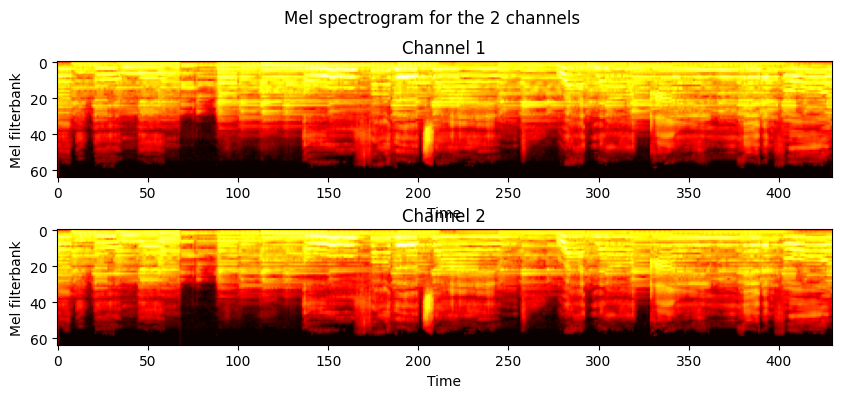

Inputs shape: torch.Size([2, 64, 430])


In [109]:
full_dataset = GenreDataset(train_df, AUDIO_DIR)

# random split
nb_samples = len(full_dataset)
nb_train_samples = int(nb_samples * 0.8)
nb_val_samples = nb_samples - nb_train_samples
train_dataset, val_dataset = random_split(full_dataset, [nb_train_samples, nb_val_samples])

# create the data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=10, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,  num_workers=10)

# get first batch
batch = next(iter(val_loader))

mel_spectrogram = batch[0][0]
# print shape of the mel spectrogram
INPUT_HEIGHT = mel_spectrogram.shape[1]
INPUT_WIDTH = mel_spectrogram.shape[2]
print(INPUT_HEIGHT, INPUT_WIDTH)
# plot the spectrograms according to nb of channels
fig, axs = plt.subplots(config['n_channels'], 1, figsize=(10, 4))
for c in range(config['n_channels']):
    axs[c].imshow(mel_spectrogram[c,:,:].numpy(), cmap='hot')
    axs[c].set_title('Channel {}'.format(c+1))
    axs[c].set_xlabel('Time')
    axs[c].set_ylabel('Mel filterbank')
fig.suptitle('Mel spectrogram for the 2 channels')
plt.show()

print("Inputs shape: {}".format(mel_spectrogram.shape))

### 4. Model creation

In [110]:
class AudioCNN(pl.LightningModule):
    """
    Audio classification model.
    """
    def __init__(self, nb_channels, nb_classes):
        """
        Constructor.
        :param nb_channels: the number of channels in the input data
        :param nb_classes: the number of classes
        :type nb_classes: int
        """
        super(AudioCNN, self).__init__()
        conv_layers = []

        self.conv1 = nn.Conv2d(nb_channels, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(in_features=64, out_features=nb_classes, bias=True)

        self.conv = nn.Sequential(*conv_layers)

        # loss function
        self.loss = nn.CrossEntropyLoss()

        # optimizer parameters
        self.lr = 0.001

        # number of classes
        self.nb_classes = nb_classes

        # save hyperparameters
        self.save_hyperparameters()

    def forward(self, x):
        """
        Forward pass.
        :param x: the input
        :type x: torch.Tensor
        :return: the output
        :rtype: torch.Tensor
        """
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        return self.linear(x)
    
    def training_step(self, batch, batch_idx):
        """
        Training step.
        :param batch: the batch
        :type batch: Tuple[torch.Tensor, torch.Tensor]
        :param batch_idx: the batch index
        :type batch_idx: int
        :return: the loss
        :rtype: torch.Tensor
        """
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        Validation step.
        :param batch: the batch
        :type batch: Tuple[torch.Tensor, torch.Tensor]
        :param batch_idx: the batch index
        :type batch_idx: int
        :return: the loss
        :rtype: torch.Tensor
        """
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        """
        Test step.
        :param batch: the batch
        :type batch: Tuple[torch.Tensor, torch.Tensor]
        :param batch_idx: the batch index
        :type batch_idx: int
        :return: the loss
        :rtype: torch.Tensor
        """
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        self.log('test_loss', loss)
        self.log('test_acc', acc)
    
    def configure_optimizers(self):
        """
        Configure optimizers.
        :return: the optimizer
        :rtype: torch.optim.Optimizer
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def _get_preds_loss_accuracy(self, batch):
        """
        Get predictions, loss and accuracy."""
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, 'multiclass', num_classes=self.nb_classes)
        return preds, loss, acc

### 5. Model training

In [111]:
# checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
)

In [112]:
model = AudioCNN(nb_channels=config['n_channels'], nb_classes=config['n_classes'])
# Create the trainer

trainer = pl.Trainer(max_epochs=config['max_epochs'], callbacks=[checkpoint_callback, EarlyStopping(monitor='val_loss', patience=10)], logger=wandb_logger)
# Fit the model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/benjy/anaconda3/envs/pi_mlodimage/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./genre-detection-tuning/d11chwbe/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name   | Type              | Params
----------------------------------------------
0  | conv1  | Conv2d            | 4

Sanity Checking: 0it [00:00, ?it/s]

/home/benjy/anaconda3/envs/pi_mlodimage/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [113]:
# load best model
model = AudioCNN.load_from_checkpoint(checkpoint_callback.best_model_path)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# log the accuracy and confusion matrix
y_true = []
y_pred = []
for batch in val_loader:
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    y_true.append(int(y))
    y_pred.append(int(preds))

# log the accuracy
wandb_logger.experiment.log({
    'best_val_acc': accuracy_score(y_true, y_pred)})

# log the confusion matrix
wandb_logger.experiment.log({
    "conf_mat": wandb.plot.confusion_matrix(probs=None,
                                            y_true=y_true,
                                            preds=y_pred,
                                            class_names=id_to_label,
                                            title="Confusion Matrix")
})

In [114]:
wandb.finish()

best_val_acc,▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
test_acc,▅▅▅▆▄▇█▅▆▅▁
test_loss,▄▁▇▃▅▄▄▆█▄▆
train_acc,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
trainer/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
val_acc,▁▁▂▃▄▄▅▅▄▅▆▅▆▅▆▆▆▁▃▅▅▄▅▆▆▆▇▅▇▇▇▇█▇█▇▇▇██
val_loss,█▇▆▅▄▄▃▃▄▃▄▂▃▄▃▄▃▆▅▄▄▃▃▃▂▂▁▂▁▄▁▁▁▁▁▂▂▂▂▃
best_val_acc,0.52716
epoch,43
